In [2]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import numpy.linalg as la
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from data_parser import parse
from data_modification import *
from visualization.plot_vcg import plot_vcg_axes, plot_3d_vcg, create_cmap, multivariate_scatter, univariate_scatter

%load_ext autoreload
%autoreload 2

In [25]:
patient_no = 0
data_path = 'C:/Users/bruker/Dropbox/SimulaSummerSchool_Group9/data/lbbb_lvdyssync'

In [4]:
patient = normalise_patient(parse(initial_path=data_path, patient_number=patient_no))
patient = resample_patient(patient)
patient = project_patient(patient)
patient_center = center_patient(patient)
patient_cyl = cylindrical_patient(patient_center)

# 3D plots of heart vectors

<IPython.core.display.Javascript object>


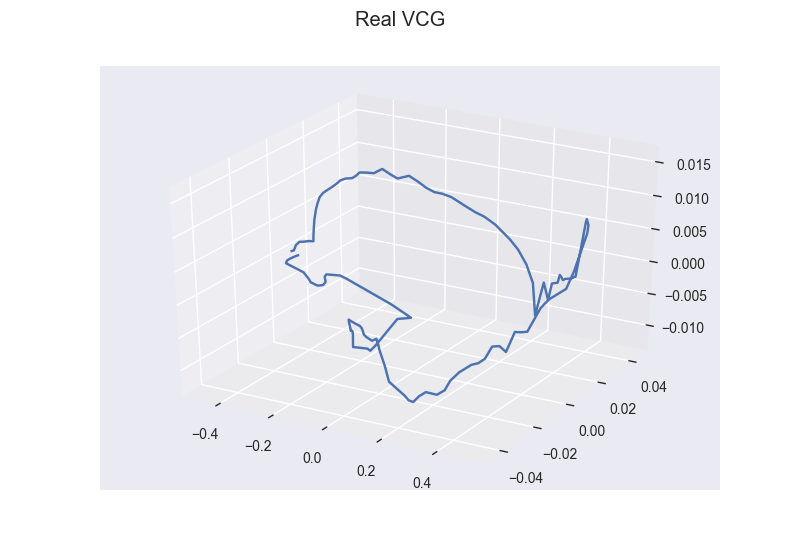

In [5]:
fig, _, _ = plot_3d_vcg(np.array(patient['vcg_real']))
fig.suptitle('Real VCG')

<IPython.core.display.Javascript object>


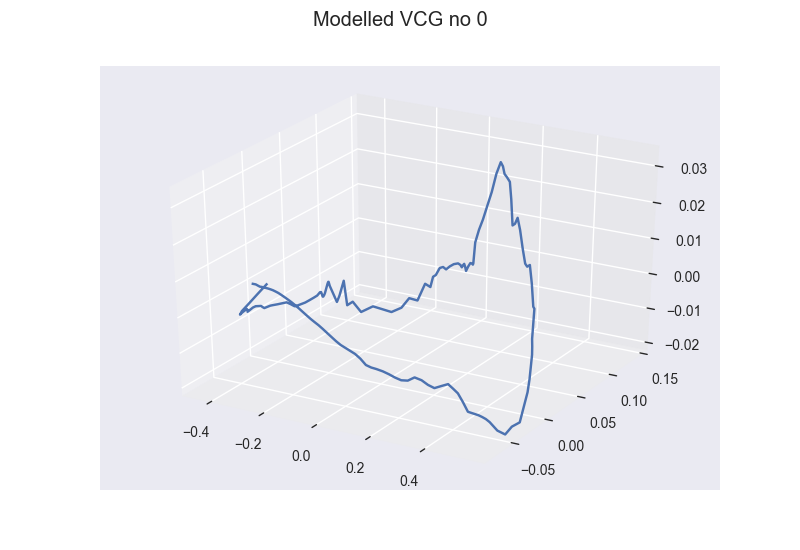

In [15]:
fig, ax, wire = plot_3d_vcg(np.array(patient['vcg_model'][0]))
fig.suptitle('Modelled VCG no 0')

pat_slider = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button = widgets.Button(description='Plot VCG')

def replot(click):
    global fig, ax, wire, pat_slider
    fig, ax, wire = plot_3d_vcg(np.array(patient['vcg_model'][pat_slider.value]), figure=fig, axes=ax, wire=wire)
    fig.suptitle('Modelled VCG no{}'.format(pat_slider.value))
    
plot_button.on_click(replot)

display(pat_slider, plot_button)

# VCG's in cartesian coordinates

<IPython.core.display.Javascript object>


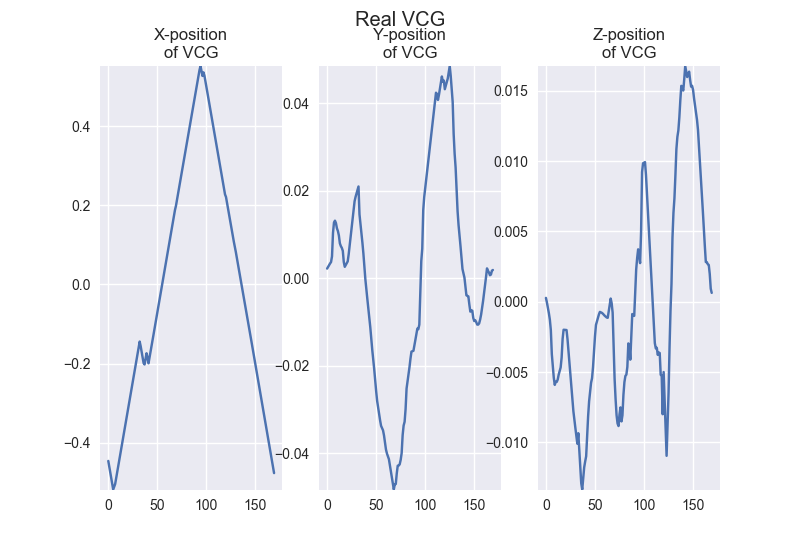

In [7]:
fig, _, _, = plot_vcg_axes(np.array(patient['vcg_real']))
fig.suptitle('Real VCG')

<IPython.core.display.Javascript object>


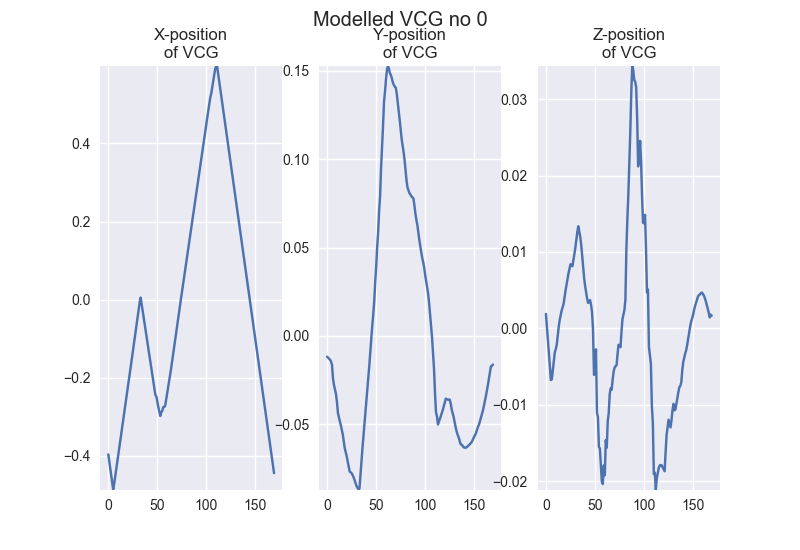

In [8]:
fig, ax, plots = plot_vcg_axes(np.array(patient['vcg_model'][0]))
fig.suptitle('Modelled VCG no 0')
pat_slider = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button = widgets.Button(description='Plot VCG')

def replot(click):
    global fig, ax, plots, pat_slider
    plot_vcg_axes(np.array(patient['vcg_model'][pat_slider.value]), figure=fig, axes=ax, plots=plots)
    fig.suptitle('Modelled VCG no {}'.format(pat_slider.value))

plot_button.on_click(replot)
display(pat_slider, plot_button)

# VCGs in cylindrical coordinates
### After centering

<IPython.core.display.Javascript object>


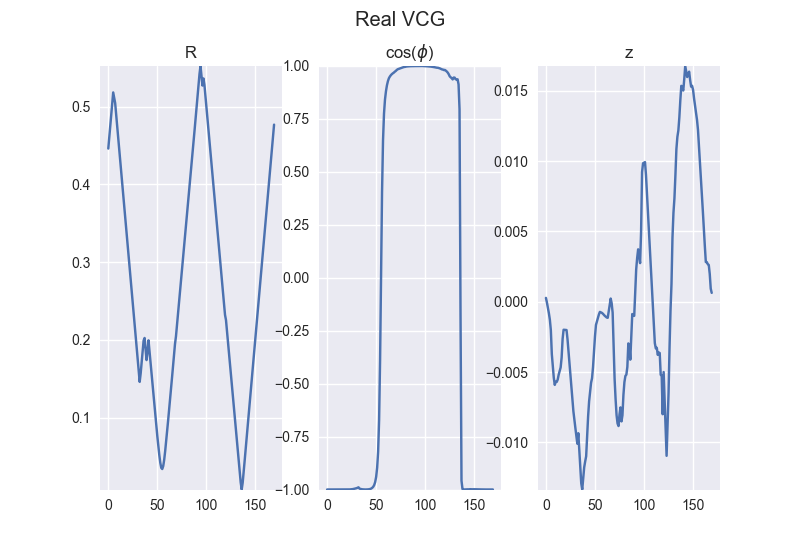

In [9]:
transforms = [None, lambda x: np.cos(x), None]
fig, _, _, = plot_vcg_axes(np.array(patient_cyl['vcg_real']), titles=['R', 'cos($\phi$)', 'z'], transforms=transforms)
fig.suptitle('Real VCG')

<IPython.core.display.Javascript object>


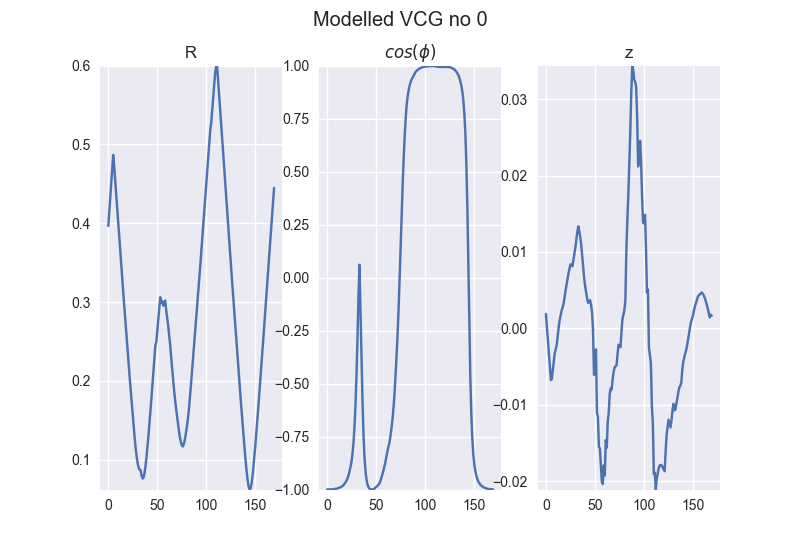

In [16]:
transforms = [None, lambda x: np.cos(x), None]
fig, ax, plots = plot_vcg_axes(np.array(patient_cyl['vcg_model'][0]), titles=['R', '$cos(\phi)$', 'z'], transforms=transforms)
fig.suptitle('Modelled VCG no 0')
pat_slider = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button = widgets.Button(description='Plot VCG')

def replot(click):
    global fig, ax, plots, pat_slider
    plot_vcg_axes(np.array(patient_cyl['vcg_model'][pat_slider.value]), figure=fig, axes=ax, plots=plots, titles=['R', 'cos($\phi$)', 'z'], transforms=transforms)
    fig.suptitle('Modelled VCG no {}'.format(pat_slider.value))

plot_button.on_click(replot)
display(pat_slider, plot_button)

# Exploration of basic features vs dyssynchrony

## 2D plots - not much information here

In [11]:
# General properties for plotting
transforms = [None, lambda x: np.cos(x), None]
dyssyncs = patient_cyl['desync'].values
cmap = create_cmap(
    dataset = dyssyncs[dyssyncs != 0],
    cmap = 'viridis'
)

<IPython.core.display.Javascript object>


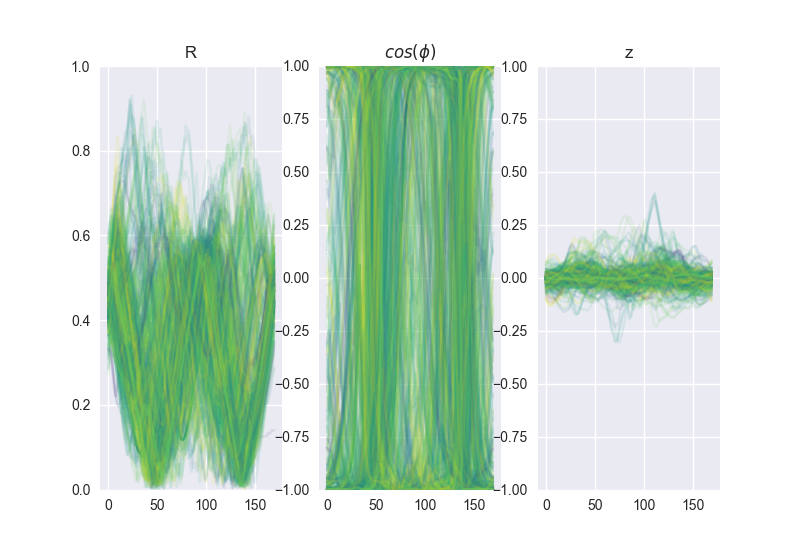

(-1, 1)

In [12]:
fig, axes, plots = fig, ax, plots = plot_vcg_axes(
    vcg = np.array(patient_cyl['vcg_model'][0]), 
    color = cmap.to_rgba(dyssyncs[0]),
    titles = ['R', '$cos(\phi)$', 'z'], 
    transforms = transforms
)

for dyssync, simulation in zip(dyssyncs, patient_cyl['vcg_model']):
    simulation = np.array(simulation)
    color = np.array(cmap.to_rgba(dyssync))
    color[3] = 0.1
    fig, axes, _ = plot_vcg_axes(
        vcg = simulation,
        figure = fig,
        axes = axes,
        color = color,
        titles = ['R', '$cos(\phi)$', 'z'],
        transforms = transforms,
        set_lims=False
    )

axes[0].set_ylim(0, 1)
axes[2].set_ylim(-1, 1)

## 3D plots - not much info here

<IPython.core.display.Javascript object>


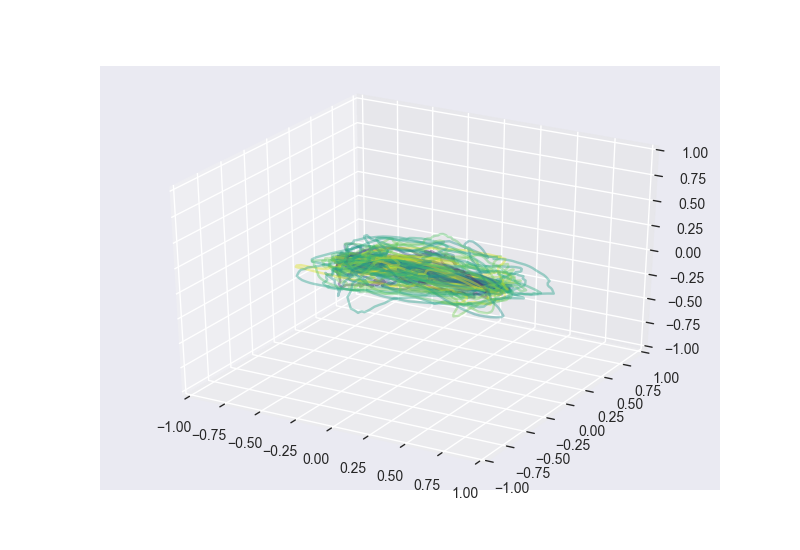

(-1, 1)

In [17]:
np.array(cmap.to_rgba(dyssyncs[0]))
color[3] = 0.4
fig, axes, _ = plot_3d_vcg(np.array(patient_center['vcg_model'][0]), color=color, set_lims=False)

i = 0
for dyssync, simulation in zip(dyssyncs, patient_center['vcg_model']):
    i += 1
    if i % 10 != 0:
        continue
    simulation = np.array(simulation)
    color = np.array(cmap.to_rgba(dyssync))
    color[3] = 0.4 
    fig, axes, _ = plot_3d_vcg(
        vcg = simulation,
        figure = fig,
        axes = axes,
        color = color,
        set_lims=False
    )

axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
axes.set_zlim(-1, 1)

# PCA scatter plot

### Compute PCA

In [18]:
data_matrix = create_data_matrix(patient_cyl)
data_matrix = data_matrix[dyssyncs != 0]
dyssyncs_clean = dyssyncs[dyssyncs != 0]

In [19]:
# Get offset vector:
mean_vals = data_matrix.mean(axis=0, keepdims=True)

# Center data matrix:
dm_center = data_matrix - mean_vals

# Compute principal components:
U, S, V = np.linalg.svd(dm_center)

<IPython.core.display.Javascript object>


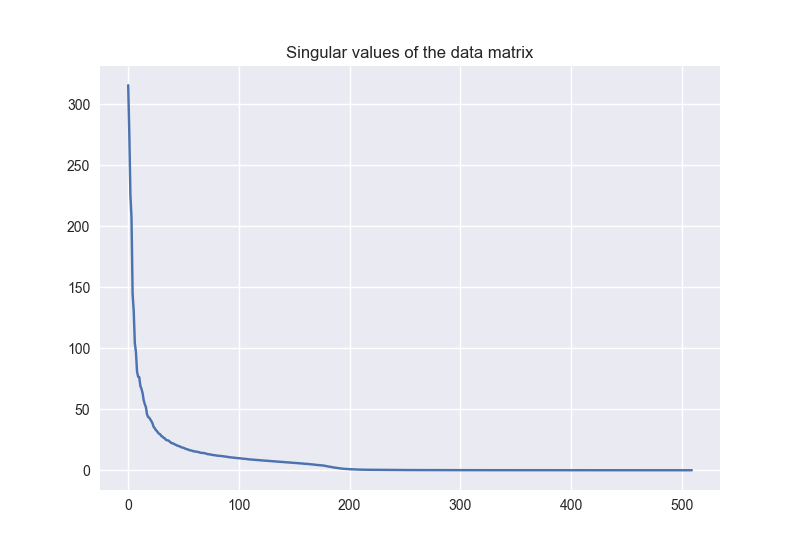

In [20]:
plt.figure()
plt.plot(S)
plt.title('Singular values of the data matrix')

## Perform coordinate change to principal axes

<IPython.core.display.Javascript object>


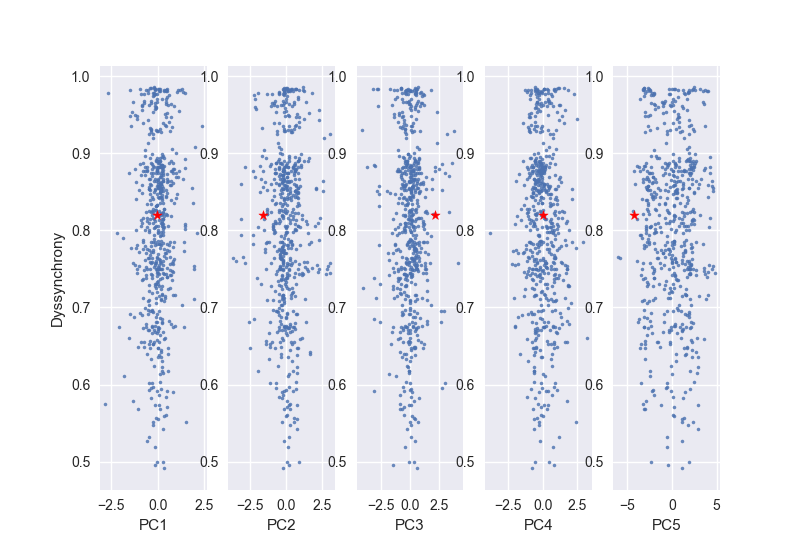

<IPython.core.display.Javascript object>


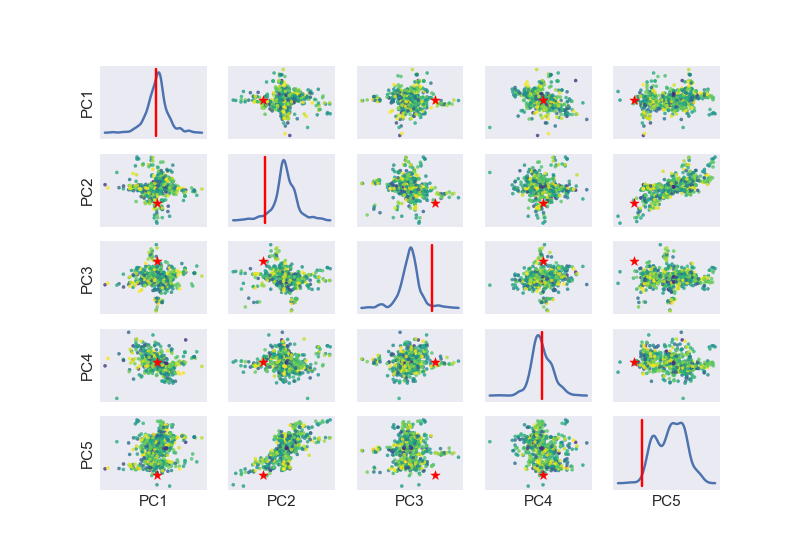

In [24]:
pca_matrix = dm_center.dot(V)
patient_vector = np.reshape(patient_cyl['vcg_real'].values, [np.prod(patient_cyl['vcg_real'].values.shape)])
pca_real = (patient_vector - mean_vals).dot(V)[0]

colors = cmap.to_rgba(dyssyncs)
column_titles = ['PC{}'.format(i+1) for i in range(pca_matrix.shape[1])] + ['Dyssynchrony']

pca_df = pd.DataFrame(
    np.concatenate([pca_matrix, dyssyncs_clean.reshape([-1, 1])], axis=1), 
    columns = column_titles
)

univariate_scatter(
    data_frame = pca_df,
    dyssynchrony = dyssyncs_clean,
    real_point = pca_real,
    real_dys = patient_cyl['opt_desync'],
    no_components=5
)

multivariate_scatter(
    data_frame = pca_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
    real_point = pca_real
)

# Kernel PCA

In [109]:
from sklearn.decomposition import KernelPCA, PCA

gamma = 0.0025


kpca = KernelPCA(kernel='rbf', gamma=gamma)

X_kpca = kpca.fit_transform(dm_center)
#X_back = kpca.inverse_transform(X_kpca)
kpca_real = kpca.transform((patient_vector - mean_vals))[0]

column_titles = ['K-PC{}'.format(i+1) for i in range(X_kpca.shape[1])] + ['Dyssynchrony']
kpca_df = pd.DataFrame(
    np.concatenate([X_kpca, dyssyncs_clean.reshape([dyssyncs_clean.shape[0], 1])], axis=1), 
    columns = column_titles
)

<IPython.core.display.Javascript object>


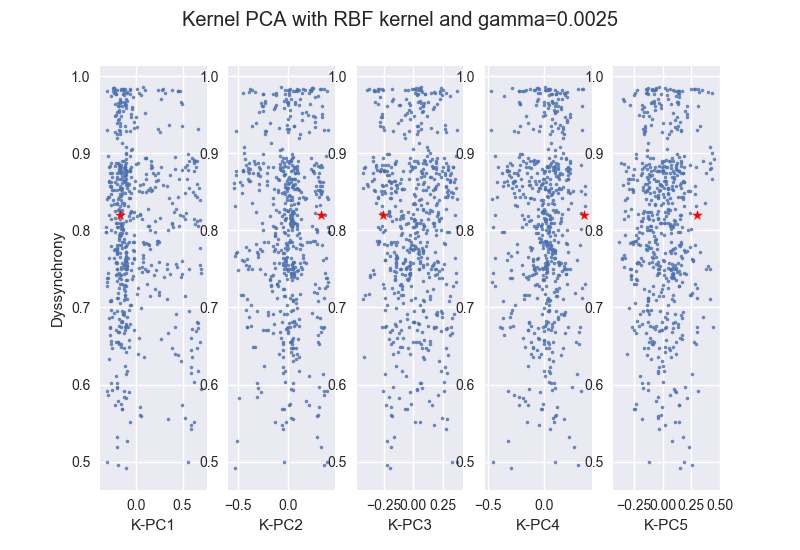

<IPython.core.display.Javascript object>


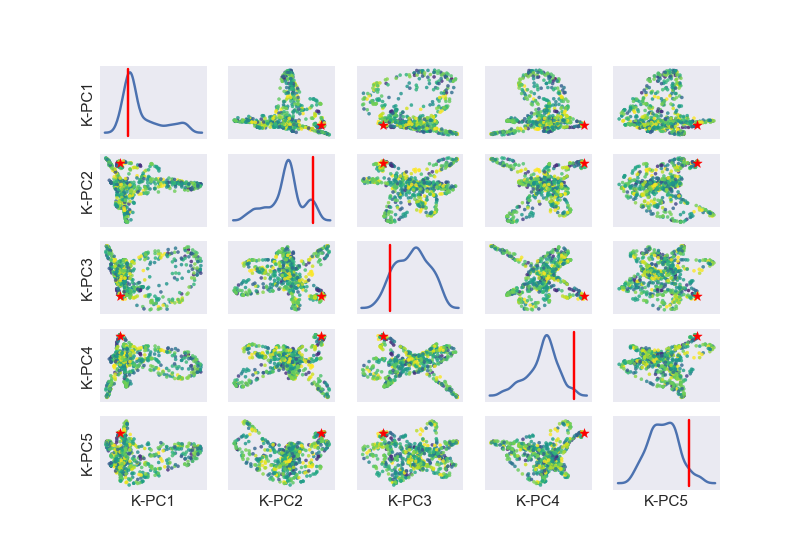

In [110]:
univariate_scatter(
    data_frame = kpca_df,
    dyssynchrony = dyssyncs_clean,
    real_point = kpca_real,
    real_dys = patient_cyl['opt_desync'],
    no_components=5
)


plt.figure(plt.get_fignums()[-1]).suptitle('Kernel PCA with RBF kernel and gamma={}'.format(gamma))

multivariate_scatter(
    data_frame = kpca_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
    real_point = kpca_real
)

# Isomaps

<IPython.core.display.Javascript object>


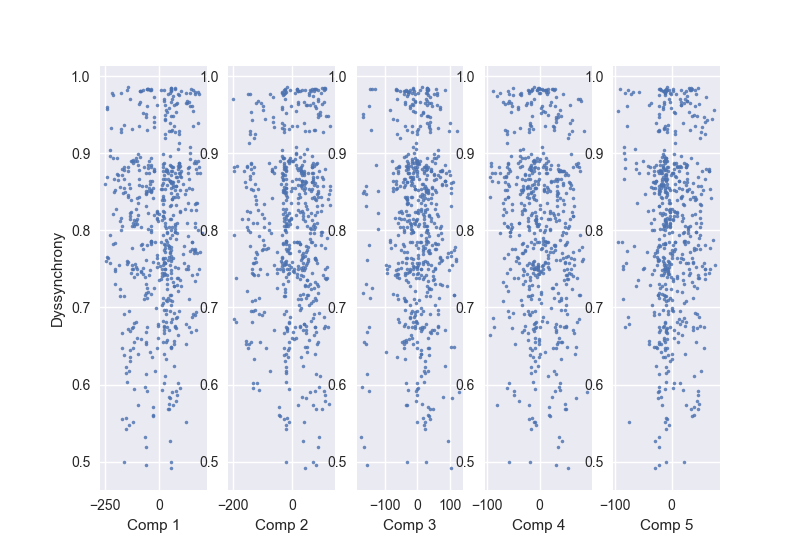

<IPython.core.display.Javascript object>


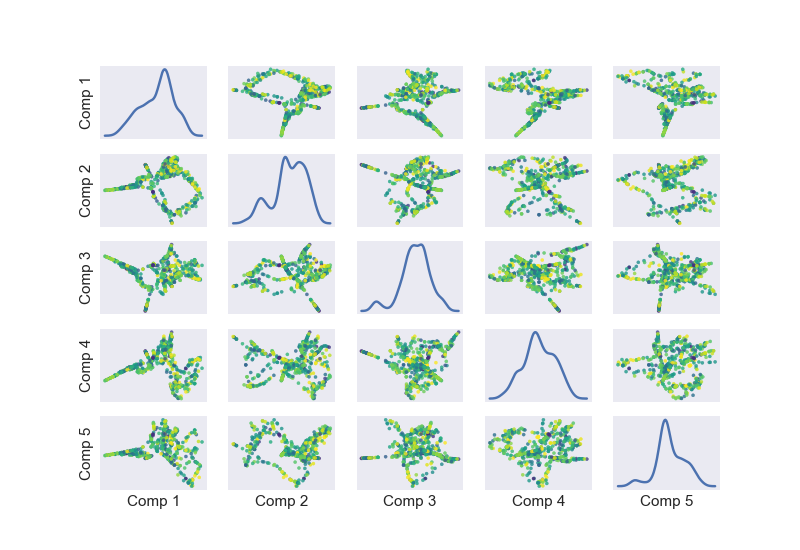

In [114]:
from sklearn.manifold import Isomap

iso_3 = Isomap(n_neighbors=4, n_components=5).fit_transform(dm_center)


isomap3_df = pd.DataFrame(
    np.concatenate((iso_3, dyssyncs_clean.reshape([-1, 1])), axis=1),
    columns = ['Comp {}'.format(i+1) for i in range(5)] + ['Dyssynchrony']
)

univariate_scatter(
    data_frame = isomap3_df,
    dyssynchrony = dyssyncs_clean,
    no_components = 5
)

multivariate_scatter(
    data_frame = isomap3_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
)

In [26]:
len(patient['vcg_model'])

608